# TensorFlow MNIST

Based on the TensorFlow tutorial at http://tensorflow.org/tutorials/mnist/pros/index.md

In [317]:
import numpy as np
import tensorflow as tf
import idx2numpy

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(4, 4)

## Read In Data

In [318]:
prefix = "/Users/jeffreyschecter/Desktop/mnist/"
train_im = idx2numpy.convert_from_file(prefix + "train-images-idx3-ubyte")
test_im = idx2numpy.convert_from_file(prefix + "t10k-images-idx3-ubyte")

In [319]:
train_labels = idx2numpy.convert_from_file(prefix + "train-labels-idx1-ubyte")
test_labels = idx2numpy.convert_from_file(prefix + "t10k-labels-idx1-ubyte")

## Throw a random forest at it

In [320]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(train_im.reshape(60000, 28 * 28), train_labels)
model_labels = clf.predict(test_im.reshape(10000, 28 * 28))
(model_labels == test_labels).mean()

0.96940000000000004

In [321]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

In [322]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

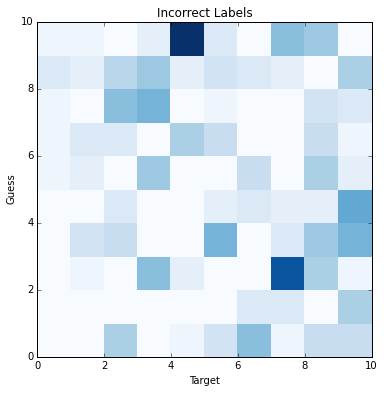

In [323]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Target")
plt.ylabel("Guess")
plt.title("Incorrect Labels")
plt.show()

## Simple softmax regression w/ TensorFlow

In [324]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [325]:
x = tf.placeholder(tf.float32, shape=[None, 28 * 28])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([28 * 28, 10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.initialize_all_variables())

In [326]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(xent)

In [327]:
train_labels_one_hot = np.zeros((60000, 10))
train_labels_one_hot[np.arange(60000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 10))
test_labels_one_hot[np.arange(10000), test_labels] = 1

In [328]:
batch_size = 1000
epochs = 10
for ep in xrange(epochs):
    print "Starting training epoch {ep}".format(ep=ep)
    for i in xrange(train_im.shape[0] / batch_size):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset].reshape(batch_size, 28 * 28),
            y_: train_labels_one_hot[start_offset:stop_offset]
        })
    accuracy_expr = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32))
    accuracy = accuracy_expr.eval(feed_dict={
        x: test_im.reshape(10000, 28 * 28),
        y_: test_labels_one_hot})
    print accuracy
    

Starting training epoch 0
0.893
Starting training epoch 1
0.9041
Starting training epoch 2
0.9092
Starting training epoch 3
0.9115
Starting training epoch 4
0.9139
Starting training epoch 5
0.9156
Starting training epoch 6
0.9165
Starting training epoch 7
0.9177
Starting training epoch 8
0.9186
Starting training epoch 9
0.9195


## Simple ConvNet w/ TensorFlow

In [329]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [330]:
def weight_variable(shape, init=0.01):
    initial = tf.random_uniform(shape, minval=-init, maxval=init)
    return tf.Variable(initial, name="weights")

def bias_variable(shape, init=0.01):
    initial = tf.constant(init, shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name="conv")

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME', name="max_pool")

def elu(x):
    pos = tf.cast(tf.greater_equal(x, 0), tf.float32)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

#### Inputs

In [331]:
x = tf.placeholder(tf.float32, [None, 28, 28])
y_ = tf.placeholder(tf.float32, [None, 10])

#### Internal Structure and Outputs

In [332]:
# Compare elu vs. tf.nnet.relu
nonlin = elu

with tf.name_scope("conv1") as scope:
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = nonlin(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

with tf.name_scope("conv2") as scope:
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = nonlin(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

with tf.name_scope("dense") as scope:
    W_dense = weight_variable([7 * 7 * 64, 1024])
    b_dense = bias_variable([1024])
    h_dense = nonlin(tf.matmul(tf.reshape(h_pool2, [-1, 7 * 7 * 64]), W_dense) + b_dense)

with tf.name_scope("dropout") as scope:
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    h_dropout = tf.nn.dropout(h_dense, keep_prob)

with tf.name_scope("softmax_output") as scope:
    W_out = weight_variable([1024, 10])
    b_out = bias_variable([10])
    y = tf.nn.softmax(tf.matmul(h_dropout, W_out) + b_out)

#### Training, Evaluation, and Initilization

In [333]:
xent = -tf.reduce_mean(y_ * tf.log(y))
learn_rate = tf.placeholder(tf.float32, [])
train_step = tf.train.AdamOptimizer(learn_rate).minimize(xent)
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

sess.run(tf.initialize_all_variables())

#### Main Loop

In [334]:
num_epochs = 1
batch_size = 200
dropout_keep_rate = 0.5
base_learn_rate = 0.0001
test_every_n_batches = 20
decay_factor = 5

batches_per_epoch = train_im.shape[0] / batch_size
for ep in xrange(num_epochs):
    for i in xrange(batches_per_epoch):
        this_learn_rate = base_learn_rate / (decay_factor ** (ep + (i / float(batches_per_epoch))))
        print "epoch {ep}, batch {ba} / {bpe}: learn rate = {lr}".format(
            ep=ep, ba=i, lr=this_learn_rate, bpe=batches_per_epoch)
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset],
            y_: train_labels_one_hot[start_offset:stop_offset],
            keep_prob: dropout_keep_rate,
            learn_rate: this_learn_rate})
        if i % test_every_n_batches == 0:
            ac = accuracy.eval(feed_dict={
                x: test_im[:100],
                y_: test_labels_one_hot[:100],
                keep_prob: 1.0})
            print "\nFinished epoch {ep}, batch {ba}: accuracy = {ac:.2f}\n".format(ep=ep, ba=i, ac=ac)
    ac = accuracy.eval(feed_dict={
        x: test_im,
        y_: test_labels_one_hot,
        keep_prob: 1.0})
    print "\nEND OF EPOCH {ep}: accuracy = {ac:.4f}\n".format(ep=ep, ac=ac)

epoch 0, batch 0 / 300: learn rate = 0.0001

Finished epoch 0, batch 0: accuracy = 0.42

epoch 0, batch 1 / 300: learn rate = 9.94649571761e-05
epoch 0, batch 2 / 300: learn rate = 9.89327770605e-05
epoch 0, batch 3 / 300: learn rate = 9.84034443363e-05
epoch 0, batch 4 / 300: learn rate = 9.7876943769e-05
epoch 0, batch 5 / 300: learn rate = 9.73532602051e-05
epoch 0, batch 6 / 300: learn rate = 9.68323785726e-05
epoch 0, batch 7 / 300: learn rate = 9.63142838798e-05
epoch 0, batch 8 / 300: learn rate = 9.57989612155e-05
epoch 0, batch 9 / 300: learn rate = 9.52863957482e-05
epoch 0, batch 10 / 300: learn rate = 9.47765727256e-05
epoch 0, batch 11 / 300: learn rate = 9.42694774745e-05
epoch 0, batch 12 / 300: learn rate = 9.37650954002e-05
epoch 0, batch 13 / 300: learn rate = 9.3263411986e-05
epoch 0, batch 14 / 300: learn rate = 9.27644127928e-05
epoch 0, batch 15 / 300: learn rate = 9.22680834591e-05
epoch 0, batch 16 / 300: learn rate = 9.17744096998e-05
epoch 0, batch 17 / 300: l

### Build a random forest based on hidden layer activations

In [335]:
import time
hidden_list = []
for i in xrange(60):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: train_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 1.81 seconds
Batch 1 in 1.65 seconds
Batch 2 in 1.69 seconds
Batch 3 in 1.69 seconds
Batch 4 in 1.71 seconds
Batch 5 in 1.73 seconds
Batch 6 in 1.68 seconds
Batch 7 in 1.73 seconds
Batch 8 in 1.69 seconds
Batch 9 in 1.69 seconds
Batch 10 in 1.69 seconds
Batch 11 in 1.70 seconds
Batch 12 in 1.75 seconds
Batch 13 in 1.70 seconds
Batch 14 in 1.71 seconds
Batch 15 in 1.71 seconds
Batch 16 in 1.69 seconds
Batch 17 in 1.71 seconds
Batch 18 in 1.71 seconds
Batch 19 in 1.72 seconds
Batch 20 in 1.70 seconds
Batch 21 in 1.75 seconds
Batch 22 in 1.85 seconds
Batch 23 in 1.75 seconds
Batch 24 in 1.71 seconds
Batch 25 in 1.70 seconds
Batch 26 in 1.71 seconds
Batch 27 in 1.98 seconds
Batch 28 in 1.67 seconds
Batch 29 in 1.70 seconds
Batch 30 in 1.75 seconds
Batch 31 in 1.70 seconds
Batch 32 in 1.72 seconds
Batch 33 in 1.72 seconds
Batch 34 in 1.71 seconds
Batch 35 in 1.71 seconds
Batch 36 in 1.70 seconds
Batch 37 in 1.70 seconds
Batch 38 in 1.73 seconds
Batch 39 in 1.71 seconds
Batch 40 i

In [336]:
hidden_train = np.array(hidden_list).reshape(60000, 1024)

In [337]:
hidden_list = []
for i in xrange(10):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: test_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 1.70 seconds
Batch 1 in 1.69 seconds
Batch 2 in 1.70 seconds
Batch 3 in 1.70 seconds
Batch 4 in 1.70 seconds
Batch 5 in 1.73 seconds
Batch 6 in 1.71 seconds
Batch 7 in 1.73 seconds
Batch 8 in 1.69 seconds
Batch 9 in 1.69 seconds


In [338]:
hidden_test = np.array(hidden_list).reshape(10000, 1024)

In [339]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(hidden_train, train_labels)
model_labels = clf.predict(hidden_test)
(model_labels == test_labels).mean()

0.97529999999999994

In [346]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

#### Example Mis-Classified Digits

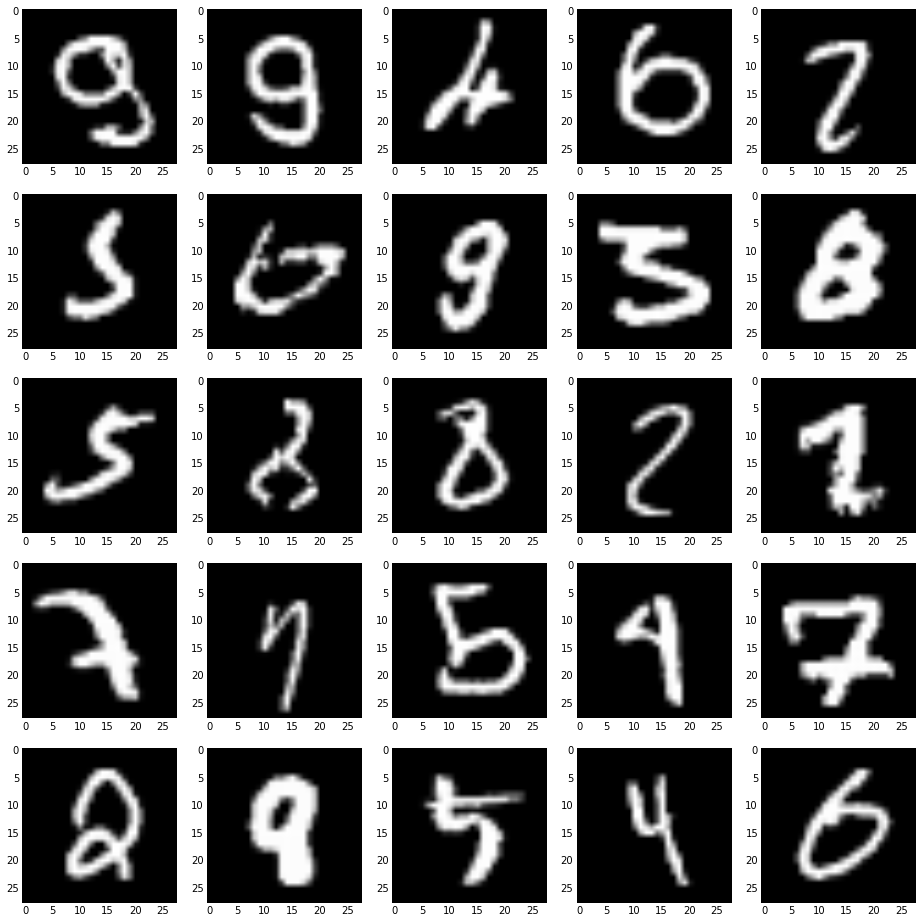

In [345]:
from matplotlib import cm

figsize(16, 16)
_, axes = plt.subplots(5, 5)
axes = axes.reshape(25)

for x in xrange(25):
    im = misses[x]
    test_label = miss_test_labels[x]
    guess_label = miss_guess_labels[x]
    ax = axes[x]
    ax.imshow(im, cmap=cm.Blues)
plt.show()

In [347]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

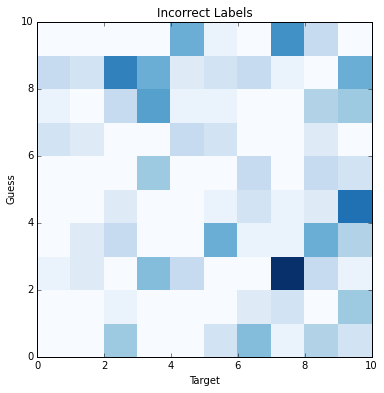

In [348]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Target")
plt.ylabel("Guess")
plt.title("Incorrect Labels")
plt.show()

## Deep Autoencoder

In [462]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


#### Inputs

In [463]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28])

#### Internal Structure and Outputs

In [464]:
def RestrictedBoltzmanMachine(inp, shape, nonlin=elu, init=0.001, scope="RBM"):
    with tf.name_scope(scope) as ns:
        W = weight_variable(shape, init=init)
        b = bias_variable([shape[1]], init=init)
        h = nonlin(tf.matmul(inp, W) + b)
        return W, b, h

# Munge input
with tf.name_scope("enc_input") as scope:
    x_scaled = x / 255.0
    x_flat = tf.reshape(x_scaled, [-1, 28 * 28])

# Encoder
W_enc1, b_enc1, h_enc1 = RestrictedBoltzmanMachine(
    x_flat, [28 * 28, 256], scope="enc1")
W_enc2, b_enc2, h_enc2 = RestrictedBoltzmanMachine(
    h_enc1, [256, 128], scope="enc2")
W_enc3, b_enc3, h_enc3 = RestrictedBoltzmanMachine(
    h_enc2, [128, 64], scope="enc3")
W_enc4, b_enc4, h_enc4 = RestrictedBoltzmanMachine(
    h_enc3, [64, 32], scope="enc4")
#W_enc5, b_enc5, h_enc5 = RestrictedBoltzmanMachine(
#    h_enc4, [32, 16], scope="enc5")

# Decoder
#W_dec5, b_dec5, h_dec5 = RestrictedBoltzmanMachine(
#    h_enc5, [16, 32], scope="dec5")
W_dec4, b_dec4, h_dec4 = RestrictedBoltzmanMachine(
    h_enc4, [32, 64], scope="dec5")
W_dec3, b_dec3, h_dec3 = RestrictedBoltzmanMachine(
    h_dec4, [64, 128], scope="dec4")
W_dec2, b_dec2, h_dec2 = RestrictedBoltzmanMachine(
    h_dec3, [128, 256], scope="dec2")
W_dec1, b_dec1, h_dec1 = RestrictedBoltzmanMachine(
    h_dec2, [256, 28 * 28], nonlin=tf.nn.sigmoid, scope="dec1")

# Munge output
with tf.name_scope("dec_output") as scope:
    y = tf.reshape(h_dec1, [-1, 28, 28])
    y_image = 255 * y

#### Training, Evaluation, and Initialization

In [465]:
mse = tf.reduce_mean(tf.pow(y - x_scaled, 2))
train_step = tf.train.AdamOptimizer(0.001).minimize(mse)

sess.run(tf.initialize_all_variables())

#### Main loop

Finished epoch 0, batch 0 after 0.63 sec: MSE=2.320e-01, MWI=-1.847e-08, MWO=-4.000e-04, max=2.310e-02
Finished epoch 0, batch 100 after 3.11 sec: MSE=6.306e-02, MWI=-8.088e-04, MWO=-2.847e-02, max=2.248e+00
Finished epoch 0, batch 200 after 5.48 sec: MSE=6.236e-02, MWI=-1.977e-03, MWO=-3.156e-02, max=2.272e+00
Finished epoch 0, batch 300 after 7.95 sec: MSE=6.195e-02, MWI=-2.662e-03, MWO=-3.542e-02, max=2.031e+00
Finished epoch 0, batch 400 after 10.25 sec: MSE=6.207e-02, MWI=-2.977e-03, MWO=-3.790e-02, max=2.036e+00
Finished epoch 0, batch 500 after 12.79 sec: MSE=6.107e-02, MWI=-2.889e-03, MWO=-4.048e-02, max=2.116e+00

END OF EPOCH 0: MSE=6.801e-02, MWI=-2.873e-03, MWO=-4.317e-02


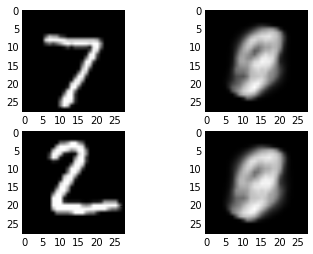

Finished epoch 1, batch 0 after 17.16 sec: MSE=6.697e-02, MWI=-2.937e-03, MWO=-4.308e-02, max=1.886e+00
Finished epoch 1, batch 100 after 19.84 sec: MSE=5.997e-02, MWI=-2.722e-03, MWO=-4.667e-02, max=1.997e+00
Finished epoch 1, batch 200 after 22.59 sec: MSE=6.090e-02, MWI=-2.809e-03, MWO=-4.923e-02, max=2.132e+00
Finished epoch 1, batch 300 after 25.45 sec: MSE=6.018e-02, MWI=-2.598e-03, MWO=-5.213e-02, max=2.142e+00
Finished epoch 1, batch 400 after 28.21 sec: MSE=6.032e-02, MWI=-2.966e-03, MWO=-5.449e-02, max=2.353e+00
Finished epoch 1, batch 500 after 30.91 sec: MSE=5.938e-02, MWI=-2.992e-03, MWO=-5.697e-02, max=2.476e+00

END OF EPOCH 1: MSE=6.297e-02, MWI=-3.008e-03, MWO=-5.924e-02


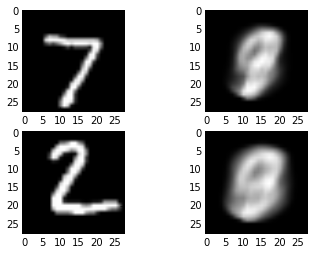

Finished epoch 2, batch 0 after 34.69 sec: MSE=6.200e-02, MWI=-3.022e-03, MWO=-5.926e-02, max=2.569e+00
Finished epoch 2, batch 100 after 37.99 sec: MSE=5.903e-02, MWI=-2.925e-03, MWO=-6.213e-02, max=2.648e+00
Finished epoch 2, batch 200 after 40.91 sec: MSE=5.906e-02, MWI=-1.978e-03, MWO=-6.405e-02, max=3.087e+00
Finished epoch 2, batch 300 after 43.46 sec: MSE=5.919e-02, MWI=-1.981e-03, MWO=-6.672e-02, max=3.402e+00
Finished epoch 2, batch 400 after 45.93 sec: MSE=5.925e-02, MWI=-2.170e-03, MWO=-6.882e-02, max=3.890e+00
Finished epoch 2, batch 500 after 48.61 sec: MSE=5.801e-02, MWI=-1.965e-03, MWO=-7.103e-02, max=4.526e+00

END OF EPOCH 2: MSE=6.101e-02, MWI=-1.727e-03, MWO=-7.203e-02


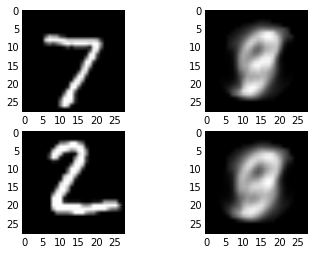

Finished epoch 3, batch 0 after 52.43 sec: MSE=6.035e-02, MWI=-1.793e-03, MWO=-7.201e-02, max=5.397e+00
Finished epoch 3, batch 100 after 55.01 sec: MSE=5.770e-02, MWI=-1.512e-03, MWO=-7.314e-02, max=5.088e+00
Finished epoch 3, batch 200 after 57.51 sec: MSE=5.731e-02, MWI=-1.131e-03, MWO=-7.383e-02, max=5.191e+00
Finished epoch 3, batch 300 after 60.22 sec: MSE=5.651e-02, MWI=-5.604e-04, MWO=-7.438e-02, max=7.646e+00
Finished epoch 3, batch 400 after 62.67 sec: MSE=5.660e-02, MWI=-7.162e-04, MWO=-7.488e-02, max=1.078e+01
Finished epoch 3, batch 500 after 65.11 sec: MSE=5.583e-02, MWI=-8.189e-04, MWO=-7.543e-02, max=1.339e+01

END OF EPOCH 3: MSE=5.848e-02, MWI=-7.939e-04, MWO=-7.545e-02


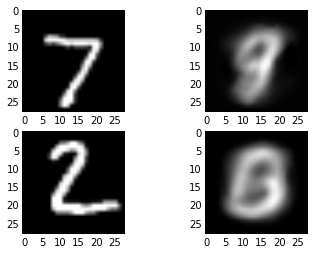

Finished epoch 4, batch 0 after 68.53 sec: MSE=5.778e-02, MWI=-8.016e-04, MWO=-7.543e-02, max=1.693e+01
Finished epoch 4, batch 100 after 71.18 sec: MSE=5.588e-02, MWI=-1.187e-03, MWO=-7.608e-02, max=1.635e+01
Finished epoch 4, batch 200 after 73.83 sec: MSE=5.572e-02, MWI=-7.674e-04, MWO=-7.614e-02, max=1.843e+01
Finished epoch 4, batch 300 after 76.59 sec: MSE=5.550e-02, MWI=-8.044e-04, MWO=-7.653e-02, max=2.005e+01
Finished epoch 4, batch 400 after 79.20 sec: MSE=5.567e-02, MWI=-9.814e-04, MWO=-7.679e-02, max=2.088e+01
Finished epoch 4, batch 500 after 81.63 sec: MSE=5.479e-02, MWI=-1.085e-03, MWO=-7.727e-02, max=2.061e+01

END OF EPOCH 4: MSE=5.757e-02, MWI=-1.311e-03, MWO=-7.717e-02


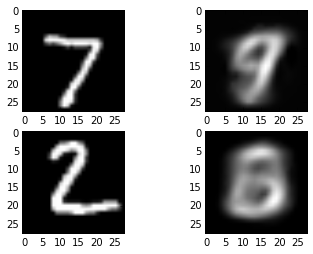

Finished epoch 5, batch 0 after 85.06 sec: MSE=5.678e-02, MWI=-1.333e-03, MWO=-7.717e-02, max=2.297e+01
Finished epoch 5, batch 100 after 87.74 sec: MSE=5.484e-02, MWI=-1.625e-03, MWO=-7.798e-02, max=2.050e+01
Finished epoch 5, batch 200 after 90.63 sec: MSE=5.508e-02, MWI=-1.247e-03, MWO=-7.755e-02, max=2.049e+01
Finished epoch 5, batch 300 after 93.53 sec: MSE=5.474e-02, MWI=-1.715e-03, MWO=-7.821e-02, max=2.007e+01
Finished epoch 5, batch 400 after 96.12 sec: MSE=5.495e-02, MWI=-1.566e-03, MWO=-7.838e-02, max=2.145e+01
Finished epoch 5, batch 500 after 98.65 sec: MSE=5.427e-02, MWI=-1.700e-03, MWO=-7.883e-02, max=2.188e+01

END OF EPOCH 5: MSE=5.682e-02, MWI=-1.867e-03, MWO=-7.886e-02


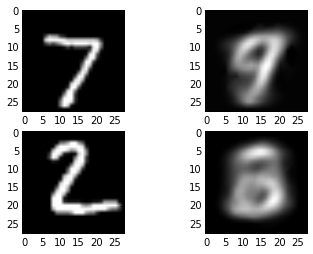

Finished epoch 6, batch 0 after 102.01 sec: MSE=5.601e-02, MWI=-1.858e-03, MWO=-7.886e-02, max=2.398e+01
Finished epoch 6, batch 100 after 104.34 sec: MSE=5.378e-02, MWI=-2.134e-03, MWO=-7.975e-02, max=2.213e+01
Finished epoch 6, batch 200 after 106.75 sec: MSE=5.417e-02, MWI=-2.464e-03, MWO=-7.928e-02, max=2.396e+01
Finished epoch 6, batch 300 after 109.11 sec: MSE=5.403e-02, MWI=-3.012e-03, MWO=-7.958e-02, max=2.435e+01
Finished epoch 6, batch 400 after 111.91 sec: MSE=5.424e-02, MWI=-3.250e-03, MWO=-7.961e-02, max=2.762e+01
Finished epoch 6, batch 500 after 114.36 sec: MSE=5.338e-02, MWI=-2.976e-03, MWO=-7.973e-02, max=2.928e+01

END OF EPOCH 6: MSE=5.610e-02, MWI=-3.314e-03, MWO=-7.939e-02


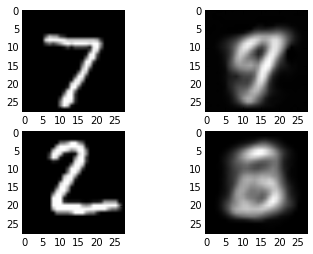

Finished epoch 7, batch 0 after 117.89 sec: MSE=5.546e-02, MWI=-3.369e-03, MWO=-7.938e-02, max=3.088e+01
Finished epoch 7, batch 100 after 120.72 sec: MSE=5.285e-02, MWI=-3.195e-03, MWO=-8.024e-02, max=2.990e+01
Finished epoch 7, batch 200 after 123.57 sec: MSE=5.305e-02, MWI=-3.703e-03, MWO=-7.960e-02, max=3.149e+01
Finished epoch 7, batch 300 after 126.01 sec: MSE=5.324e-02, MWI=-3.835e-03, MWO=-7.963e-02, max=3.208e+01
Finished epoch 7, batch 400 after 128.53 sec: MSE=5.254e-02, MWI=-3.558e-03, MWO=-7.974e-02, max=3.389e+01
Finished epoch 7, batch 500 after 130.93 sec: MSE=5.247e-02, MWI=-3.785e-03, MWO=-7.967e-02, max=3.606e+01

END OF EPOCH 7: MSE=5.551e-02, MWI=-4.257e-03, MWO=-7.963e-02


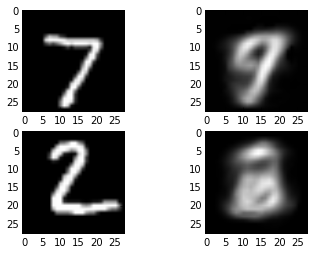

Finished epoch 8, batch 0 after 134.27 sec: MSE=5.477e-02, MWI=-4.261e-03, MWO=-7.961e-02, max=3.573e+01
Finished epoch 8, batch 100 after 136.99 sec: MSE=5.176e-02, MWI=-3.890e-03, MWO=-8.056e-02, max=3.592e+01
Finished epoch 8, batch 200 after 139.46 sec: MSE=5.248e-02, MWI=-4.674e-03, MWO=-7.990e-02, max=3.562e+01
Finished epoch 8, batch 300 after 142.12 sec: MSE=5.232e-02, MWI=-5.042e-03, MWO=-8.030e-02, max=3.684e+01
Finished epoch 8, batch 400 after 145.01 sec: MSE=5.011e-02, MWI=-3.872e-03, MWO=-8.150e-02, max=3.173e+01
Finished epoch 8, batch 500 after 147.17 sec: MSE=4.876e-02, MWI=-3.862e-03, MWO=-8.149e-02, max=3.422e+01

END OF EPOCH 8: MSE=5.010e-02, MWI=-4.058e-03, MWO=-8.173e-02


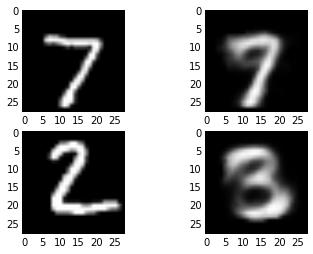

Finished epoch 9, batch 0 after 150.47 sec: MSE=4.981e-02, MWI=-4.103e-03, MWO=-8.171e-02, max=3.964e+01
Finished epoch 9, batch 100 after 153.24 sec: MSE=4.764e-02, MWI=-4.011e-03, MWO=-8.167e-02, max=4.060e+01
Finished epoch 9, batch 200 after 155.53 sec: MSE=4.684e-02, MWI=-4.215e-03, MWO=-8.149e-02, max=4.398e+01
Finished epoch 9, batch 300 after 158.05 sec: MSE=4.658e-02, MWI=-4.564e-03, MWO=-8.175e-02, max=4.355e+01
Finished epoch 9, batch 400 after 160.71 sec: MSE=4.599e-02, MWI=-5.556e-03, MWO=-8.188e-02, max=4.530e+01
Finished epoch 9, batch 500 after 163.20 sec: MSE=4.481e-02, MWI=-5.384e-03, MWO=-8.362e-02, max=5.031e+01

END OF EPOCH 9: MSE=4.795e-02, MWI=-5.405e-03, MWO=-8.564e-02


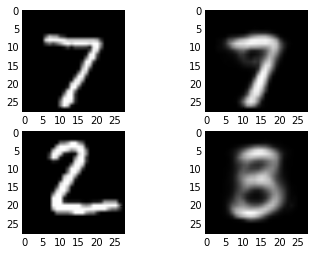

Finished epoch 10, batch 0 after 167.05 sec: MSE=4.690e-02, MWI=-5.373e-03, MWO=-8.562e-02, max=5.369e+01
Finished epoch 10, batch 100 after 169.65 sec: MSE=4.323e-02, MWI=-5.854e-03, MWO=-8.538e-02, max=5.635e+01
Finished epoch 10, batch 200 after 172.12 sec: MSE=4.310e-02, MWI=-5.362e-03, MWO=-8.506e-02, max=5.442e+01
Finished epoch 10, batch 300 after 175.05 sec: MSE=4.234e-02, MWI=-5.851e-03, MWO=-8.502e-02, max=5.728e+01
Finished epoch 10, batch 400 after 177.63 sec: MSE=4.176e-02, MWI=-5.527e-03, MWO=-8.495e-02, max=5.908e+01
Finished epoch 10, batch 500 after 180.40 sec: MSE=4.132e-02, MWI=-6.123e-03, MWO=-8.503e-02, max=5.694e+01

END OF EPOCH 10: MSE=4.392e-02, MWI=-6.359e-03, MWO=-8.502e-02


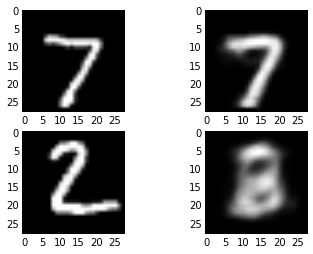

Finished epoch 11, batch 0 after 184.85 sec: MSE=4.366e-02, MWI=-6.368e-03, MWO=-8.499e-02, max=5.951e+01
Finished epoch 11, batch 100 after 187.71 sec: MSE=4.088e-02, MWI=-6.689e-03, MWO=-8.503e-02, max=6.018e+01
Finished epoch 11, batch 200 after 190.34 sec: MSE=4.107e-02, MWI=-6.897e-03, MWO=-8.493e-02, max=5.949e+01
Finished epoch 11, batch 300 after 193.12 sec: MSE=4.032e-02, MWI=-6.962e-03, MWO=-8.496e-02, max=5.847e+01
Finished epoch 11, batch 400 after 195.97 sec: MSE=3.912e-02, MWI=-6.624e-03, MWO=-8.470e-02, max=5.895e+01
Finished epoch 11, batch 500 after 198.62 sec: MSE=3.827e-02, MWI=-6.696e-03, MWO=-8.477e-02, max=5.756e+01

END OF EPOCH 11: MSE=4.069e-02, MWI=-6.650e-03, MWO=-8.476e-02


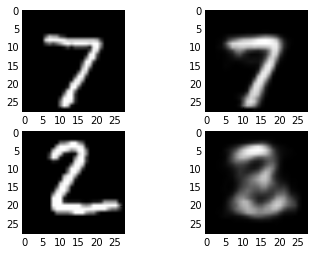

Finished epoch 12, batch 0 after 202.24 sec: MSE=3.963e-02, MWI=-6.628e-03, MWO=-8.476e-02, max=5.729e+01
Finished epoch 12, batch 100 after 205.31 sec: MSE=3.664e-02, MWI=-7.197e-03, MWO=-8.428e-02, max=5.466e+01
Finished epoch 12, batch 200 after 208.59 sec: MSE=3.642e-02, MWI=-7.381e-03, MWO=-8.413e-02, max=5.430e+01
Finished epoch 12, batch 300 after 211.66 sec: MSE=3.579e-02, MWI=-7.457e-03, MWO=-8.374e-02, max=5.296e+01
Finished epoch 12, batch 400 after 214.55 sec: MSE=3.543e-02, MWI=-7.766e-03, MWO=-8.359e-02, max=5.428e+01
Finished epoch 12, batch 500 after 217.38 sec: MSE=3.533e-02, MWI=-8.218e-03, MWO=-8.348e-02, max=5.404e+01

END OF EPOCH 12: MSE=3.712e-02, MWI=-8.407e-03, MWO=-8.362e-02


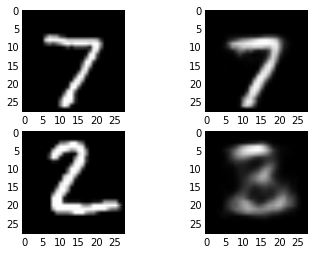

Finished epoch 13, batch 0 after 221.27 sec: MSE=3.635e-02, MWI=-8.413e-03, MWO=-8.361e-02, max=5.440e+01
Finished epoch 13, batch 100 after 224.20 sec: MSE=3.382e-02, MWI=-8.619e-03, MWO=-8.354e-02, max=5.706e+01
Finished epoch 13, batch 200 after 227.15 sec: MSE=3.275e-02, MWI=-8.576e-03, MWO=-8.396e-02, max=5.930e+01
Finished epoch 13, batch 300 after 230.04 sec: MSE=3.202e-02, MWI=-8.871e-03, MWO=-8.388e-02, max=5.923e+01
Finished epoch 13, batch 400 after 232.87 sec: MSE=3.179e-02, MWI=-8.918e-03, MWO=-8.390e-02, max=6.065e+01
Finished epoch 13, batch 500 after 235.90 sec: MSE=3.175e-02, MWI=-9.233e-03, MWO=-8.390e-02, max=6.052e+01

END OF EPOCH 13: MSE=3.418e-02, MWI=-9.370e-03, MWO=-8.396e-02


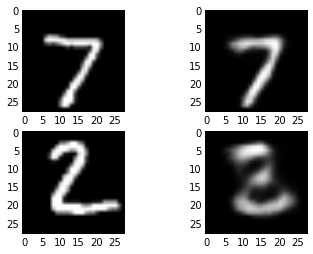

Finished epoch 14, batch 0 after 239.63 sec: MSE=3.283e-02, MWI=-9.364e-03, MWO=-8.394e-02, max=5.855e+01
Finished epoch 14, batch 100 after 242.67 sec: MSE=3.120e-02, MWI=-9.672e-03, MWO=-8.370e-02, max=5.773e+01
Finished epoch 14, batch 200 after 245.84 sec: MSE=3.071e-02, MWI=-9.963e-03, MWO=-8.379e-02, max=5.676e+01
Finished epoch 14, batch 300 after 249.07 sec: MSE=3.002e-02, MWI=-1.010e-02, MWO=-8.403e-02, max=5.296e+01
Finished epoch 14, batch 400 after 251.82 sec: MSE=2.975e-02, MWI=-1.015e-02, MWO=-8.424e-02, max=5.254e+01
Finished epoch 14, batch 500 after 254.69 sec: MSE=2.950e-02, MWI=-1.030e-02, MWO=-8.431e-02, max=5.268e+01

END OF EPOCH 14: MSE=3.123e-02, MWI=-1.026e-02, MWO=-8.436e-02


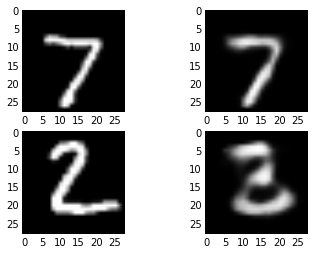

Finished epoch 15, batch 0 after 258.63 sec: MSE=3.004e-02, MWI=-1.027e-02, MWO=-8.435e-02, max=5.137e+01
Finished epoch 15, batch 100 after 261.70 sec: MSE=2.871e-02, MWI=-1.050e-02, MWO=-8.421e-02, max=5.075e+01
Finished epoch 15, batch 200 after 264.53 sec: MSE=2.819e-02, MWI=-1.079e-02, MWO=-8.424e-02, max=4.884e+01
Finished epoch 15, batch 300 after 267.31 sec: MSE=2.769e-02, MWI=-1.084e-02, MWO=-8.418e-02, max=4.670e+01
Finished epoch 15, batch 400 after 270.25 sec: MSE=2.755e-02, MWI=-1.074e-02, MWO=-8.416e-02, max=4.743e+01
Finished epoch 15, batch 500 after 273.29 sec: MSE=2.756e-02, MWI=-1.109e-02, MWO=-8.402e-02, max=4.738e+01

END OF EPOCH 15: MSE=2.914e-02, MWI=-1.128e-02, MWO=-8.391e-02


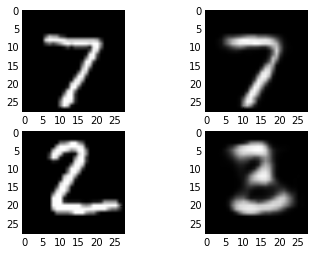

Finished epoch 16, batch 0 after 276.93 sec: MSE=2.813e-02, MWI=-1.127e-02, MWO=-8.391e-02, max=4.575e+01
Finished epoch 16, batch 100 after 279.89 sec: MSE=2.704e-02, MWI=-1.156e-02, MWO=-8.370e-02, max=4.665e+01
Finished epoch 16, batch 200 after 282.92 sec: MSE=2.659e-02, MWI=-1.167e-02, MWO=-8.361e-02, max=4.472e+01
Finished epoch 16, batch 300 after 285.63 sec: MSE=2.625e-02, MWI=-1.183e-02, MWO=-8.356e-02, max=4.279e+01
Finished epoch 16, batch 400 after 288.50 sec: MSE=2.611e-02, MWI=-1.216e-02, MWO=-8.354e-02, max=4.416e+01
Finished epoch 16, batch 500 after 291.29 sec: MSE=2.595e-02, MWI=-1.245e-02, MWO=-8.280e-02, max=4.398e+01

END OF EPOCH 16: MSE=2.797e-02, MWI=-1.265e-02, MWO=-8.277e-02


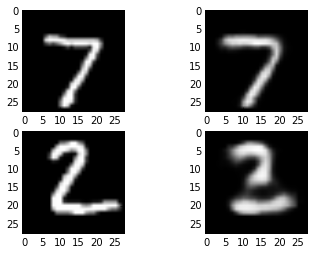

Finished epoch 17, batch 0 after 295.19 sec: MSE=2.712e-02, MWI=-1.265e-02, MWO=-8.276e-02, max=4.293e+01
Finished epoch 17, batch 100 after 298.47 sec: MSE=2.548e-02, MWI=-1.273e-02, MWO=-8.263e-02, max=4.390e+01
Finished epoch 17, batch 200 after 301.71 sec: MSE=2.502e-02, MWI=-1.292e-02, MWO=-8.258e-02, max=4.317e+01
Finished epoch 17, batch 300 after 304.90 sec: MSE=2.447e-02, MWI=-1.298e-02, MWO=-8.249e-02, max=4.171e+01
Finished epoch 17, batch 400 after 307.71 sec: MSE=2.398e-02, MWI=-1.307e-02, MWO=-8.248e-02, max=4.262e+01
Finished epoch 17, batch 500 after 310.62 sec: MSE=2.397e-02, MWI=-1.338e-02, MWO=-8.238e-02, max=4.026e+01

END OF EPOCH 17: MSE=2.554e-02, MWI=-1.356e-02, MWO=-8.230e-02


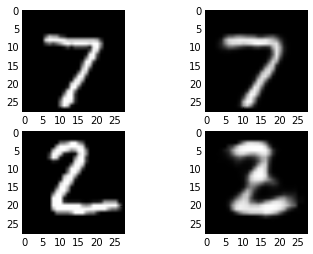

Finished epoch 18, batch 0 after 314.57 sec: MSE=2.511e-02, MWI=-1.354e-02, MWO=-8.230e-02, max=3.958e+01
Finished epoch 18, batch 100 after 317.56 sec: MSE=2.339e-02, MWI=-1.384e-02, MWO=-8.219e-02, max=4.068e+01
Finished epoch 18, batch 200 after 320.47 sec: MSE=2.285e-02, MWI=-1.412e-02, MWO=-8.208e-02, max=3.976e+01
Finished epoch 18, batch 300 after 323.65 sec: MSE=2.238e-02, MWI=-1.432e-02, MWO=-8.205e-02, max=3.780e+01
Finished epoch 18, batch 400 after 326.81 sec: MSE=2.202e-02, MWI=-1.471e-02, MWO=-8.201e-02, max=3.940e+01
Finished epoch 18, batch 500 after 329.59 sec: MSE=2.170e-02, MWI=-1.495e-02, MWO=-8.210e-02, max=3.713e+01

END OF EPOCH 18: MSE=2.329e-02, MWI=-1.520e-02, MWO=-8.217e-02


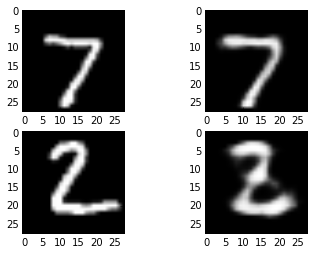

Finished epoch 19, batch 0 after 333.31 sec: MSE=2.258e-02, MWI=-1.519e-02, MWO=-8.217e-02, max=3.632e+01
Finished epoch 19, batch 100 after 336.48 sec: MSE=2.133e-02, MWI=-1.546e-02, MWO=-8.205e-02, max=3.650e+01
Finished epoch 19, batch 200 after 339.34 sec: MSE=2.082e-02, MWI=-1.558e-02, MWO=-8.196e-02, max=3.620e+01
Finished epoch 19, batch 300 after 342.39 sec: MSE=2.048e-02, MWI=-1.571e-02, MWO=-8.196e-02, max=3.444e+01
Finished epoch 19, batch 400 after 345.33 sec: MSE=2.028e-02, MWI=-1.589e-02, MWO=-8.192e-02, max=3.543e+01
Finished epoch 19, batch 500 after 347.87 sec: MSE=2.030e-02, MWI=-1.597e-02, MWO=-8.186e-02, max=3.406e+01

END OF EPOCH 19: MSE=2.204e-02, MWI=-1.615e-02, MWO=-8.186e-02


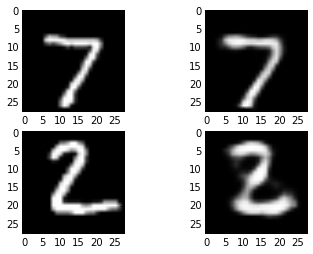

Finished epoch 20, batch 0 after 351.53 sec: MSE=2.123e-02, MWI=-1.615e-02, MWO=-8.185e-02, max=3.344e+01
Finished epoch 20, batch 100 after 354.19 sec: MSE=2.014e-02, MWI=-1.634e-02, MWO=-8.176e-02, max=3.363e+01
Finished epoch 20, batch 200 after 357.08 sec: MSE=1.968e-02, MWI=-1.641e-02, MWO=-8.172e-02, max=3.330e+01
Finished epoch 20, batch 300 after 359.74 sec: MSE=1.936e-02, MWI=-1.656e-02, MWO=-8.176e-02, max=3.248e+01
Finished epoch 20, batch 400 after 362.73 sec: MSE=1.934e-02, MWI=-1.671e-02, MWO=-8.177e-02, max=3.369e+01
Finished epoch 20, batch 500 after 365.28 sec: MSE=1.916e-02, MWI=-1.674e-02, MWO=-8.176e-02, max=3.268e+01

END OF EPOCH 20: MSE=2.173e-02, MWI=-1.692e-02, MWO=-8.175e-02


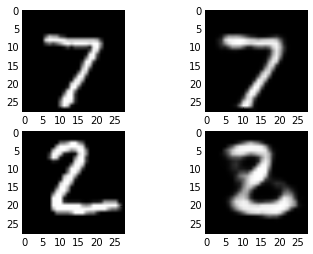

Finished epoch 21, batch 0 after 369.38 sec: MSE=2.079e-02, MWI=-1.693e-02, MWO=-8.175e-02, max=3.230e+01
Finished epoch 21, batch 100 after 372.10 sec: MSE=1.914e-02, MWI=-1.719e-02, MWO=-8.169e-02, max=3.278e+01
Finished epoch 21, batch 200 after 374.84 sec: MSE=1.868e-02, MWI=-1.728e-02, MWO=-8.170e-02, max=3.235e+01
Finished epoch 21, batch 300 after 377.76 sec: MSE=1.826e-02, MWI=-1.748e-02, MWO=-8.176e-02, max=3.188e+01
Finished epoch 21, batch 400 after 380.44 sec: MSE=1.837e-02, MWI=-1.766e-02, MWO=-8.179e-02, max=3.300e+01
Finished epoch 21, batch 500 after 383.44 sec: MSE=1.827e-02, MWI=-1.763e-02, MWO=-8.177e-02, max=3.185e+01

END OF EPOCH 21: MSE=2.069e-02, MWI=-1.781e-02, MWO=-8.175e-02


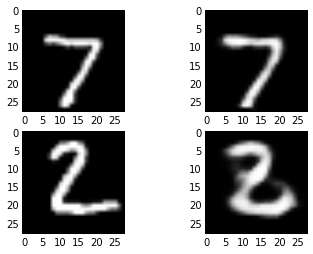

Finished epoch 22, batch 0 after 387.09 sec: MSE=1.994e-02, MWI=-1.782e-02, MWO=-8.174e-02, max=3.282e+01
Finished epoch 22, batch 100 after 389.86 sec: MSE=1.816e-02, MWI=-1.802e-02, MWO=-8.170e-02, max=3.247e+01
Finished epoch 22, batch 200 after 392.75 sec: MSE=1.771e-02, MWI=-1.812e-02, MWO=-8.170e-02, max=3.185e+01
Finished epoch 22, batch 300 after 395.46 sec: MSE=1.744e-02, MWI=-1.825e-02, MWO=-8.175e-02, max=3.094e+01
Finished epoch 22, batch 400 after 398.44 sec: MSE=1.742e-02, MWI=-1.833e-02, MWO=-8.177e-02, max=3.195e+01
Finished epoch 22, batch 500 after 401.33 sec: MSE=1.732e-02, MWI=-1.834e-02, MWO=-8.173e-02, max=3.129e+01

END OF EPOCH 22: MSE=1.945e-02, MWI=-1.843e-02, MWO=-8.172e-02


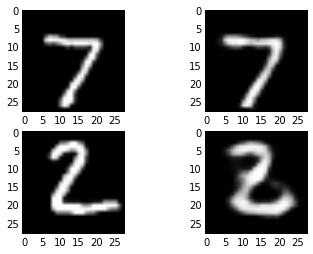

Finished epoch 23, batch 0 after 405.35 sec: MSE=1.866e-02, MWI=-1.844e-02, MWO=-8.172e-02, max=3.196e+01
Finished epoch 23, batch 100 after 408.17 sec: MSE=1.726e-02, MWI=-1.851e-02, MWO=-8.171e-02, max=3.132e+01
Finished epoch 23, batch 200 after 410.89 sec: MSE=1.687e-02, MWI=-1.858e-02, MWO=-8.173e-02, max=3.074e+01
Finished epoch 23, batch 300 after 413.99 sec: MSE=1.668e-02, MWI=-1.864e-02, MWO=-8.177e-02, max=2.946e+01
Finished epoch 23, batch 400 after 417.43 sec: MSE=1.662e-02, MWI=-1.870e-02, MWO=-8.181e-02, max=3.012e+01
Finished epoch 23, batch 500 after 421.15 sec: MSE=1.653e-02, MWI=-1.872e-02, MWO=-8.178e-02, max=2.981e+01

END OF EPOCH 23: MSE=1.846e-02, MWI=-1.882e-02, MWO=-8.179e-02


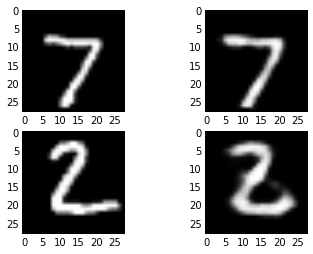

Finished epoch 24, batch 0 after 425.66 sec: MSE=1.754e-02, MWI=-1.882e-02, MWO=-8.179e-02, max=3.007e+01
Finished epoch 24, batch 100 after 428.58 sec: MSE=1.656e-02, MWI=-1.885e-02, MWO=-8.180e-02, max=2.923e+01
Finished epoch 24, batch 200 after 431.22 sec: MSE=1.621e-02, MWI=-1.891e-02, MWO=-8.183e-02, max=2.869e+01
Finished epoch 24, batch 300 after 434.06 sec: MSE=1.604e-02, MWI=-1.894e-02, MWO=-8.186e-02, max=2.725e+01
Finished epoch 24, batch 400 after 436.76 sec: MSE=1.600e-02, MWI=-1.905e-02, MWO=-8.191e-02, max=2.729e+01
Finished epoch 24, batch 500 after 439.80 sec: MSE=1.592e-02, MWI=-1.909e-02, MWO=-8.189e-02, max=2.737e+01

END OF EPOCH 24: MSE=1.802e-02, MWI=-1.916e-02, MWO=-8.191e-02


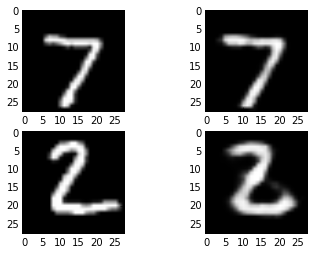

Finished epoch 25, batch 0 after 445.08 sec: MSE=1.705e-02, MWI=-1.916e-02, MWO=-8.191e-02, max=2.775e+01
Finished epoch 25, batch 100 after 447.62 sec: MSE=1.596e-02, MWI=-1.922e-02, MWO=-8.191e-02, max=2.697e+01
Finished epoch 25, batch 200 after 450.65 sec: MSE=1.564e-02, MWI=-1.925e-02, MWO=-8.196e-02, max=2.658e+01
Finished epoch 25, batch 300 after 453.45 sec: MSE=1.566e-02, MWI=-1.923e-02, MWO=-8.199e-02, max=2.573e+01
Finished epoch 25, batch 400 after 456.17 sec: MSE=1.538e-02, MWI=-1.936e-02, MWO=-8.202e-02, max=2.578e+01
Finished epoch 25, batch 500 after 458.71 sec: MSE=1.546e-02, MWI=-1.940e-02, MWO=-8.201e-02, max=2.607e+01

END OF EPOCH 25: MSE=1.733e-02, MWI=-1.943e-02, MWO=-8.203e-02


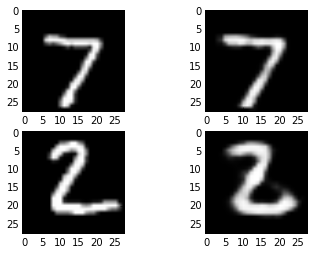

Finished epoch 26, batch 0 after 462.97 sec: MSE=1.641e-02, MWI=-1.944e-02, MWO=-8.203e-02, max=2.667e+01
Finished epoch 26, batch 100 after 465.62 sec: MSE=1.525e-02, MWI=-1.947e-02, MWO=-8.199e-02, max=2.531e+01
Finished epoch 26, batch 200 after 468.54 sec: MSE=1.495e-02, MWI=-1.946e-02, MWO=-8.200e-02, max=2.483e+01
Finished epoch 26, batch 300 after 471.27 sec: MSE=1.487e-02, MWI=-1.944e-02, MWO=-8.203e-02, max=2.411e+01
Finished epoch 26, batch 400 after 473.75 sec: MSE=1.464e-02, MWI=-1.952e-02, MWO=-8.204e-02, max=2.416e+01
Finished epoch 26, batch 500 after 476.57 sec: MSE=1.477e-02, MWI=-1.954e-02, MWO=-8.201e-02, max=2.439e+01

END OF EPOCH 26: MSE=1.659e-02, MWI=-1.959e-02, MWO=-8.201e-02


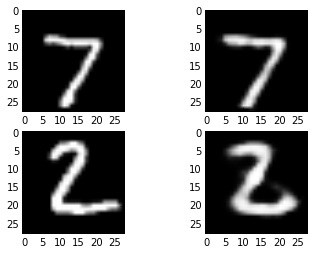

Finished epoch 27, batch 0 after 480.46 sec: MSE=1.591e-02, MWI=-1.960e-02, MWO=-8.201e-02, max=2.439e+01
Finished epoch 27, batch 100 after 483.02 sec: MSE=1.463e-02, MWI=-1.960e-02, MWO=-8.195e-02, max=2.352e+01
Finished epoch 27, batch 200 after 486.01 sec: MSE=1.435e-02, MWI=-1.963e-02, MWO=-8.199e-02, max=2.343e+01
Finished epoch 27, batch 300 after 488.70 sec: MSE=1.422e-02, MWI=-1.965e-02, MWO=-8.203e-02, max=2.260e+01
Finished epoch 27, batch 400 after 491.91 sec: MSE=1.405e-02, MWI=-1.968e-02, MWO=-8.203e-02, max=2.233e+01
Finished epoch 27, batch 500 after 494.48 sec: MSE=1.414e-02, MWI=-1.973e-02, MWO=-8.203e-02, max=2.266e+01

END OF EPOCH 27: MSE=1.621e-02, MWI=-1.979e-02, MWO=-8.203e-02


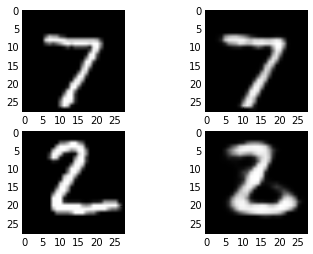

Finished epoch 28, batch 0 after 498.25 sec: MSE=1.574e-02, MWI=-1.978e-02, MWO=-8.203e-02, max=2.326e+01
Finished epoch 28, batch 100 after 500.90 sec: MSE=1.413e-02, MWI=-1.978e-02, MWO=-8.197e-02, max=2.221e+01
Finished epoch 28, batch 200 after 503.37 sec: MSE=1.388e-02, MWI=-1.983e-02, MWO=-8.202e-02, max=2.258e+01
Finished epoch 28, batch 300 after 506.24 sec: MSE=1.370e-02, MWI=-1.980e-02, MWO=-8.206e-02, max=2.254e+01
Finished epoch 28, batch 400 after 509.46 sec: MSE=1.352e-02, MWI=-1.984e-02, MWO=-8.205e-02, max=2.173e+01
Finished epoch 28, batch 500 after 511.93 sec: MSE=1.359e-02, MWI=-1.989e-02, MWO=-8.207e-02, max=2.116e+01

END OF EPOCH 28: MSE=1.559e-02, MWI=-1.990e-02, MWO=-8.206e-02


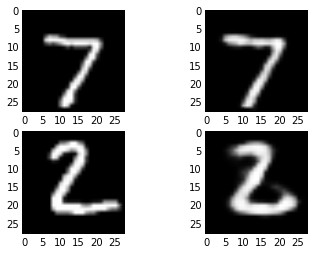

Finished epoch 29, batch 0 after 515.46 sec: MSE=1.516e-02, MWI=-1.989e-02, MWO=-8.207e-02, max=2.282e+01
Finished epoch 29, batch 100 after 518.02 sec: MSE=1.365e-02, MWI=-1.994e-02, MWO=-8.201e-02, max=2.149e+01
Finished epoch 29, batch 200 after 520.49 sec: MSE=1.346e-02, MWI=-1.996e-02, MWO=-8.206e-02, max=2.187e+01
Finished epoch 29, batch 300 after 523.35 sec: MSE=1.321e-02, MWI=-1.990e-02, MWO=-8.210e-02, max=2.176e+01
Finished epoch 29, batch 400 after 525.87 sec: MSE=1.310e-02, MWI=-1.989e-02, MWO=-8.206e-02, max=2.102e+01
Finished epoch 29, batch 500 after 528.26 sec: MSE=1.319e-02, MWI=-1.997e-02, MWO=-8.210e-02, max=2.046e+01

END OF EPOCH 29: MSE=1.473e-02, MWI=-1.993e-02, MWO=-8.210e-02


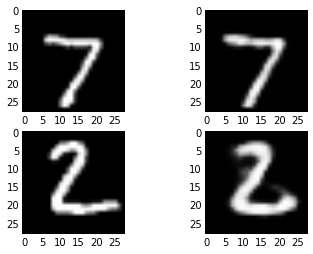

In [466]:
num_epochs = 30
batch_size = 100
test_every_n_batches = 100

figsize(6, 4)

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
for ep in xrange(num_epochs):
    for i in xrange(batches_per_epoch):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={x: train_im[start_offset:stop_offset]})
        if i % test_every_n_batches == 0:
            er, W_in, W_out, he1, he2, hd2 = sess.run(
                [mse, W_enc1, W_dec1, h_enc1, h_enc2, h_dec2],
                feed_dict={x: test_im[:100]})
            mv = max(he1.max(), he2.max(), hd2.max())
            print ("Finished epoch {ep}, batch {ba} after {t:.2f} sec: "
                   "MSE={er:.3e}, MWI={win:.3e}, MWO={wout:.3e}, max={mv:.3e}").format(
                ep=ep, ba=i, t=time.time() - mark, er=er, win=W_in.mean(), wout=W_out.mean(), mv=mv)
    er = mse.eval(feed_dict={x: test_im})
    W_in = W_enc1.eval().mean()
    W_out = W_dec1.eval().mean()
    print "\nEND OF EPOCH {ep}: MSE={er:.3e}, MWI={win:.3e}, MWO={wout:.3e}".format(
        ep=ep, er=er, win=W_in, wout=W_out)
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(test_im[0], cmap=cm.Blues)
    ax2.imshow(y_image.eval(feed_dict={x: test_im[0:1]}).reshape(28, 28), cmap=cm.Blues)
    ax3.imshow(test_im[1], cmap=cm.Blues)
    ax4.imshow(y_image.eval(feed_dict={x: test_im[1:2]}).reshape(28, 28), cmap=cm.Blues)
    plt.show()
    

### Random Forest based on Autoencoder Compressed Representation

In [467]:
compressed_train = h_enc4.eval({x: train_im})
compressed_test = h_enc4.eval({x: test_im})

In [468]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(compressed_train, train_labels)
model_labels = clf.predict(compressed_test)
(model_labels == test_labels).mean()

0.95989999999999998

### Visualize the Components of the Compressed Representation

In [527]:
figsize(16, 8)
diag = np.zeros([32, 32])
np.fill_diagonal(diag, 1)
diag
components = y_image.eval(feed_dict={h_enc4: diag})

In [506]:
hidden_archetypes = [
    h_enc4.eval(feed_dict={x_scaled: test_im[test_labels == i] / 255.0}).mean(axis=0)
    for i in xrange(10)]

Average Activations of the Most Compressed Hidden Layer for Digit '6'


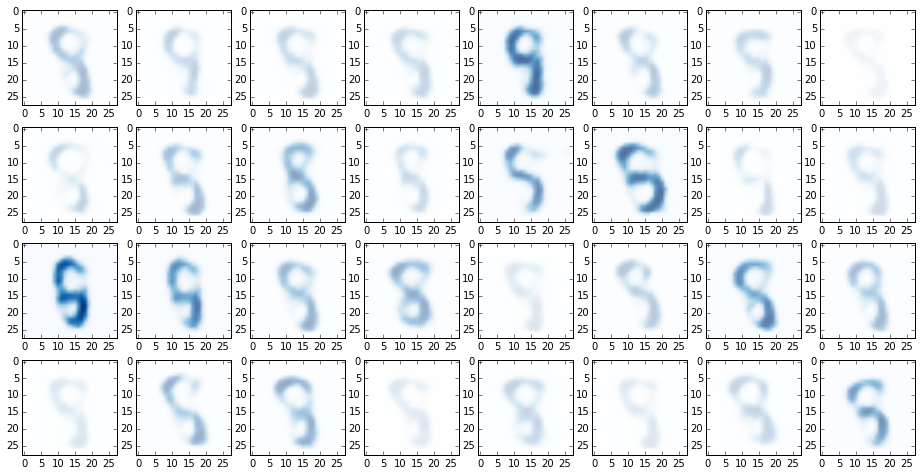

In [545]:
from ipywidgets import interact

def ShowComponentWeights(digit):
    print "Average Activations of the Most Compressed Hidden Layer for Digit '{i}'".format(i=digit)
    _, axes = plt.subplots(4, 8)
    axes = axes.reshape(32)
    max_weight = hidden_archetypes[digit].max() + 1
    for x, comp in enumerate(components):
        weight = (hidden_archetypes[digit][x] + 1) / max_weight
        axes[x].imshow(comp, alpha=weight, cmap=cm.Blues)
    plt.show()

interact(ShowComponentWeights, digit=(0, 9))
None